# Classification with CNN

[Saeed Salehi, Philipp Seegerer, PyTorch Tutorials]

Our goal here is to build our first convolution neural net for classification task and get familiar with the classes and functions that are commonly used.

In [1]:
# # header
import sys
sys.path.append("./")

In [2]:
# imports
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [3]:
# please define the data directory
data_root = "./data"
assert os.path.exists(data_root), "Data directory not found!"


## Setup
Before going further, we need to choose the hardware to train our model on!

In [4]:
# set the device
num_workers, pin_memory = 4, False
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # NVIDIA GPU
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")  # Apple Silicon (Metal)
else:
    device = torch.device("cpu") # CPU (slowest option)

print(f"Device set to {device}!")


Device set to mps!


In [5]:
# Helper function to count the number of learble parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


## Dataset
Pytorch comes with a library dedicated to Vision tasks, called `torchvision`. Besides vision-related modules and classes. `torchvision` also comes with some popular datasets such as *MNIST*, *CelebA*, *CIFAR10* built-in. [TorchVision Built-in datasets](https://pytorch.org/vision/stable/datasets.html)

Please note that if the data-files are not available, `torchvision` can download them for you.

In [6]:
# Please choose one of the two datasets and comment out the other
from torchvision.datasets import MNIST

train_ds = MNIST(root=data_root,  # location for the data to be downloaded if not found
                train=True,  # use the training set (if false, it will use the test set)
                transform=torchvision.transforms.ToTensor(),  # transform the data to torch tensors
                download=True,  # download the data if not found, 
)

In [7]:
# randomly splitting the dataset into 90% training and 10% validation
n_train = int(0.9 * len(train_ds))
n_val = len(train_ds) - n_train
train_ds, val_ds = torch.utils.data.random_split(train_ds, [n_train, n_val])

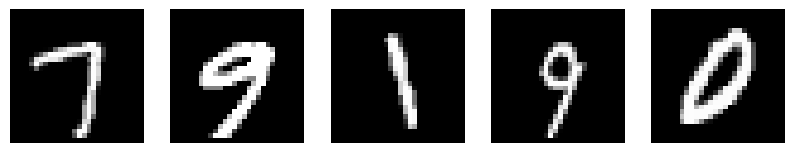

In [8]:
# plotting the first 5 images
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axs[i].imshow(train_ds[i][0].squeeze(), cmap="gray")
    axs[i].axis("off")
plt.show()

### Custom Image Dataset

Since not every dataset is already available in PyTorch, we need to learn how to build a class of our dataset that could *read* and *pre-process* the data samples for training. PyTorch comes with the base calss Dataset `torch.utils.data.Dataset` which could built further for any specific data and task.

Even for the available datasets, we would often want to augment the images or change them to our desired shape or format. For pre-defined augmentations (transformations) we can pass them to `transform` argument in the dataset, but we could also build our own Dataset class.

[illustration of transforms](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py)

[ Datasets & DataLoaders tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

every `Dataset` class can have any number of functions and attributes, but it must always include the three functions `__init__`, `__len__` which returns the length (number of samples) in the dataset and `__getitem__(i)` that takes i (an integer in the range of dataset length) and returns curated data-sample outputs.

**Note**: It's important to note that loading the whole dataset into the RAM is often impossible and unnecessary. Therefore it is important to design your `Dataset` to read the data from the hard-drive upon request.

In [9]:
from torch.utils.data import Dataset
# ?Dataset

In [10]:
# Here we will use create a custom dataset class to add noise and pre-built transformations.
class CustomImageDataset(Dataset):
    def __init__(self, ds_: Dataset, noise_level: float = 0.0):
        self.ds = ds_  # the vanila dataset
        self.noise_level = noise_level  # the noise level to be added to the images
        
        # >>>>> YOUR CODE HERE
        # Task: include RandomRotation transform in the composition
        # raise NotImplementedError("Replace this line by your code.")
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Pad((2, 2, 2, 2)),
            torchvision.transforms.RandomRotation(15)
        ])
        # <<<<< END YOUR CODE

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, i: int):
        image, label = self.ds.__getitem__(i)

        # apply the padding transformation
        image = self.transform(image)
        
        # add noise if the noise_level is greater than 0
        if self.noise_level > 0.0:
            image += self.noise_level * torch.randn_like(image)
            image = torch.clamp(image, 0.0, 1.0)  # clip the values to be between 0 and 1
        
        return image, label


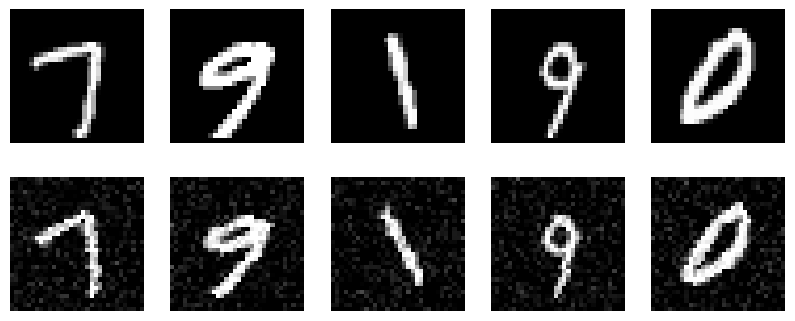

In [11]:
# plotting the first 5 images with and without noise
train_ds_n = CustomImageDataset(train_ds, noise_level=0.1)
valid_ds_n = CustomImageDataset(val_ds, noise_level=0.0, )

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axs[0, i].imshow(train_ds[i][0].squeeze(), cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].imshow(train_ds_n[i][0].squeeze(), cmap="gray")
    axs[1, i].axis("off")
plt.show()

## Dataloader

The `Dataset` retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s `multiprocessing` to speed up data retrieval. DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [12]:
from torch.utils.data import DataLoader
# ?DataLoader

In [13]:
train_dataloader = DataLoader(train_ds_n,  # the dataset to be used
                              batch_size=64,  # the number of samples per batch
                              shuffle=True,  # shuffle the dataset at every epoch
                              )

val_dataloader = DataLoader(valid_ds_n,  # the dataset to be used
                            batch_size=64,  # the number of samples per batch
                            shuffle=False,  # do not shuffle the dataset
                            )


**NOTE:** above we only passed 3 arguments but you should familiarize yourself with other arguments such as `num_workers` and `pin_memory`, since they can effect the speed on which the data is prepared depending on your hardware.

[Performance Tuning Guide](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html)

In [15]:
#  Since `Dataloader` is of generator class, we can use it to iterate over the dataset
for images, labels in train_dataloader:
    print(f"Images batch shape: {images.shape}, Labels batch shape: {labels.shape}")
    break

# or using the `iter` function
images, labels = next(iter(train_dataloader))
print(f"Batch size: {images.size(0)} \n"
       "Number of channels: {images.size(1)} \n"
       "Height: {images.size(2)} \n"
       "Width: {images.size(3)}")

Images batch shape: torch.Size([64, 1, 32, 32]), Labels batch shape: torch.Size([64])
Batch size: 64 
Number of channels: {images.size(1)} 
Height: {images.size(2)} 
Width: {images.size(3)}


## network architecture

Since Pooling does not have any learnable parameter, it can be done by `nn.MaxPool2d(kernel_size, stride)` or `F.max_pool2d(input, kernel_size, stride)`. This also applies to Dropout and activation functions!

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # >>>>> YOUR CODE HERE
        # raise NotImplementedError("Replace this line by your code.")
        # self.conv1 = ...  # nn.Conv2d with in_channels=1, out_channels=4, kernel_size=3, stride=1, padding='same'
        # self.conv2 = ...  # nn.Conv2d with in_channels=4, out_channels=8, kernel_size=3, stride=1, padding='same'
        # self.maxpool = ...  # nn.MaxPool2d with kernel_size=2, stride=2
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding='same')
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        # <<<<< END YOUR CODE

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding='same')
        # >>>>> YOUR CODE HERE
        # raise NotImplementedError("Replace this line by your code.")
        # self.adapool = ...  # AdaptiveAvgPool2d withoutput_size=(4, 4)
        self.adapool = nn.AdaptiveAvgPool2d(output_size=(4, 4))
        # <<<<< END YOUR CODE

        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.adapool(x)

        x = x.view(-1, 256)  # Reshape to vector
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.25)
        y = self.fc3(x)
        return y


In [17]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = F.cross_entropy
print(model)
print(f"The model has {count_parameters(model):,} learnable parameters.")

Net(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (adapool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
The model has 22,682 learnable parameters.


In [18]:
def train_epoch(model, data_loader, optimizer, criterion, device):
    
    # Set network to training mode
    model.train()
    
    # Move model to device
    model.to(device)
    
    # Iterate over dataset
    losses = list()
    for data, target in data_loader:
        # Move data to GPU
        data, target = data.to(device), target.to(device)
        
        # Compute output
        output = model(data)
        
        # Compute crossentropy loss
        loss = criterion(output, target)
        
        # Clear gradients
        optimizer.zero_grad(set_to_none=True)

        # Compute gradient
        loss.backward()
        
        # Perform gradient descent
        optimizer.step()
        
        # Track losses
        losses.append(loss.item())

    # Set network to evaluation mode
    model.eval()

    # Return loss at end of epoch
    return losses

In [19]:
def eval_function(model, data_loader, criterion, device):
    
    label_loss = 0.0  # loss for the entire dataset
    correct = 0  # number of correct predictions

    # Set network to training mode
    model.eval()
    
    # Move model to device
    model.to(device)

    with torch.no_grad():
        # Iterate over dataset
        for data, target in data_loader:
            # Move data to device
            data, target = data.to(device), target.to(device)

            # Compute output
            output = model(data)
            
            # Compute the loss
            loss = criterion(output, target)
            label_loss += loss.item() * data.size(0)

            # Compute the number of correct predictions
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
        
    label_loss /= len(data_loader.dataset)
    correct_percent = 100.0 * correct / len(data_loader.dataset)

    print(f"Average Validation loss: {label_loss:.4f}, Validation Accuracy: {correct}/{len(data_loader.dataset)} ({correct_percent:.2f}%)")

In [20]:
losses = list()
for epoch in tqdm(range(5)):
    epoch_losses = train_epoch(model, train_dataloader, optimizer, criterion, device)
    print(f"Average loss in epoch {epoch}: {torch.tensor(epoch_losses).mean().item():.5f}")
    losses.extend(epoch_losses)

eval_function(model, val_dataloader, criterion, device)

 20%|██        | 1/5 [00:23<01:34, 23.55s/it]

Average loss in epoch 0: 0.98237


 40%|████      | 2/5 [00:46<01:09, 23.30s/it]

Average loss in epoch 1: 0.44763


 60%|██████    | 3/5 [01:09<00:46, 23.09s/it]

Average loss in epoch 2: 0.33587


 80%|████████  | 4/5 [01:32<00:23, 23.02s/it]

Average loss in epoch 3: 0.28488


100%|██████████| 5/5 [01:55<00:00, 23.14s/it]

Average loss in epoch 4: 0.25427


Average Validation loss: 0.2366, Validation Accuracy: 5586/6000 (93.10%)


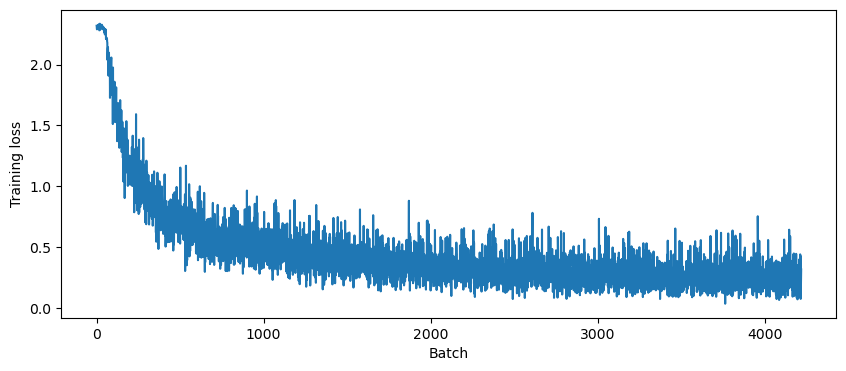

In [21]:
# plotting the loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Training loss")
plt.show()

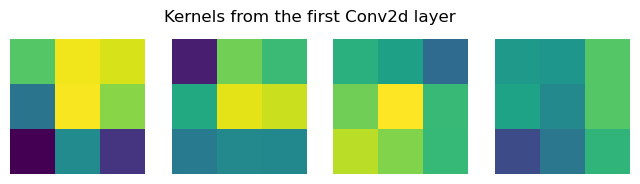

In [22]:
# visualize the learned kernels from the first Conv2d
# >>>>> YOUR CODE HERE
# raise NotImplementedError("Replace this line by your code.")
# conv1_kernels = ...  # get the kernels (weight attributes) of conv1 layer
conv1_kernels = model.conv1.weight.detach().cpu()
# <<<<< END YOUR CODE
v_min, vmax = conv1_kernels.min(), conv1_kernels.max()
plt.figure(figsize=(8, 2))
plt.suptitle("Kernels from the first Conv2d layer")
for i in range(conv1_kernels.size(0)):
    plt.subplot(1, 4, i+1)
    plt.imshow(conv1_kernels[i][0], vmin=v_min, vmax=vmax)
    plt.axis("off")
plt.show()
